## Unidad 5: Regresión Lineal
### Actividad 09

### Sobre la base de datos

* En esta actividad trabajaremos con un registro de clientes de un banco e información sobre su salud financiera. La base contenida en el csv `Credit` contiene las siguientes variables:

* `Income`: Ingreso anual disponible en miles de dólares.
* `Limit`: Límite del crédito.
* `Rating`: Ranking del crédito.
* `Cards`: Cantidad de tarjetas de credito.
* `Age`: Edad del usuario.
* `Education`: Años de educación del usuario.
* `Gender`: ¿Hombre o mujer?
* `Student`: ¿Es estudiante?
* `Married`: ¿Está casado?
* `Ethnicity`: Etnicidad del usuario (Caucásico, Afroamericano, Asiático)
* `Balance`: Promedio de deuda en tarjeta de crédito de usuario.

* Para efectos prácticos del ejercicio, nos interesa saber sobre los determinantes de la variación en el promedio de deuda en tarjeta de crédito. A lo largo del ejercicio generaremos modelos econométricos para inspeccionar los efectos de distintos atributos.

## Ejercicio 1: Prepare el ambiente de trabajo

* Importe las librerías básicas para el análisis de datos.
* Incluya los import base de `statsmodels`.
* Importe la base de datos `Credit.csv` y elimine la columna `Unnamed: 0`.
* Siguiendo las buenas prácticas, genere variables binarias para capturar el efecto del grupo minoritario en cada variable. Para el caso de `Ethnicity`, genere binarias para `AfricanAmerican` y `Asian`.
    - _tip_: Utilice `value_counts()` para revisar la cantidad de casos en las variables categóricas.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_csv('Credit.csv')
df = df.drop(columns="Unnamed: 0")

In [3]:
df.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [4]:
df['Ethnicity'].value_counts()

Caucasian           199
Asian               102
African American     99
Name: Ethnicity, dtype: int64

In [5]:
df['African American'] = np.where(df['Ethnicity'] == 'African American', 1, 0)

In [6]:
df['Asian'] = np.where(df['Ethnicity'] == 'Asian', 1, 0)

In [7]:
df = df.drop(columns="Ethnicity")

Dado que para la variable `Ethnicity` la categoría `Caucasian` tiene la mayoría de datos, no se binariza, ya que de lo contrario generaría multicolinealidad en el modelo de datos, por esta misma razón, se elimina la variable y sólo se trabaja con las binarizadas.

Si $Asian = 0$ y $African American = 0$ $\Rightarrow$ es `Caucasian`

Aplicar binarización de variables, recordar que al binarizar se le debe dar valor 0 a la categoría que contiene mayor cantidad de datos

In [8]:
df['Gender'].value_counts()

Female    207
 Male     193
Name: Gender, dtype: int64

In [9]:
df['Student'].value_counts()

No     360
Yes     40
Name: Student, dtype: int64

In [10]:
df['Married'].value_counts()

Yes    245
No     155
Name: Married, dtype: int64

In [11]:
df['Bin_Gender'] = np.where(df['Gender'] == 'Female', 0, 1)
df['Bin_Student'] = np.where(df['Student'] == 'Yes', 1, 0)
df['Bin_Married'] = np.where(df['Married'] == 'No', 1, 0)

In [12]:
df = df.drop(columns="Gender")
df = df.drop(columns="Student")
df = df.drop(columns="Married")

In [13]:
df.head()

,Income,Limit,Rating,Cards,Age,Education,Balance,African American,Asian,Bin_Gender,Bin_Student,Bin_Married
0,14.891,3606,283,2,34,11,333,0,0,1,0,0
1,106.025,6645,483,3,82,15,903,0,1,0,1,0
2,104.593,7075,514,4,71,11,580,0,1,1,0,1
3,148.924,9504,681,3,36,11,964,0,1,0,0,1
4,55.882,4897,357,2,68,16,331,0,0,1,0,0


## Ejercicio 2: Genere gráficos descriptivos para las variables contínuas

* Genere una función llamada `plot_hist` que genere un histograma de la variable e indique la media y mediana de la misma. Agrege una leyenda para indicar qué representa cada línea.
* ¿Cuál es el comportamiento de `Balance`, `Income`, `Cards` y `Rating`?

In [14]:
def plot_hist(dataframe, var, mean=False, median=False):
    
    """
    Función que gráfica histograma de una variable a partir de un dataframe. 
    Los argumentos opcionales agregarán una línea vertical indicando la media y la mediana 
    """
    
    tmp_var = dataframe[var].dropna()
    plot = plt.hist(tmp_var, color='slategrey',alpha=.4, )
    if mean is True:
        plt.axvline(tmp_var.mean(), color='tomato', lw=3, linestyle='--', label="Mean")
    if median is True:
        plt.axvline(tmp_var.median(), color='dodgerblue', lw=3, linestyle='--', label="Median")

    plt.legend()
    plt.xlabel(var)

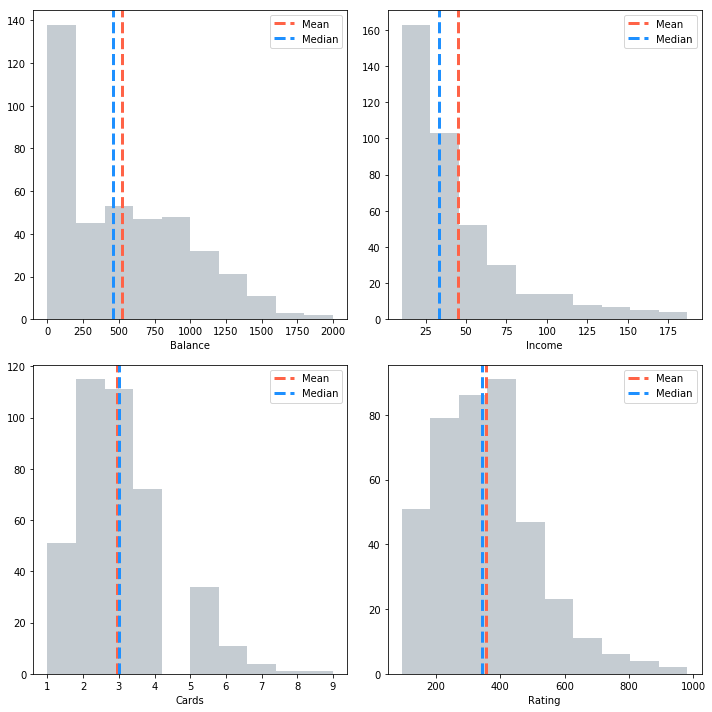

In [15]:
variables = ['Balance','Income', 'Cards', 'Rating']
plt.figure(figsize=(10,10))
for index, value in enumerate (variables):
    plt.subplot(2,2,index+1); plot_hist(df,value,True,True)
    plt.tight_layout()


Las medianas de las variables `Balance`, `Income`, `Cards` y `Rating` están muy ajustadas a la media.

## Ejercicio 3: Regresión Lineal Simple

* A continuación generaremos una serie de modelos simples:

![alttext](eq1.gif)

* Utilizando `statsmodels`, comente brevemente los siguientes puntos:
    - ¿Qué variable presenta un mayor poder explicativo de la variabilidad de `Balance`?
    - ¿Qué podemos decir sobre el comportamiento de `Student`?
    - ¿Qué pasa si aplicamos una prueba de hipótesis para muestras independientes de `Balance` entre aquellos que son y no son estudiantes?

In [28]:
model1 = smf.ols('Balance ~ Bin_Student', df)
model1 = model1.fit()
results = model1.summary()
results.tables[0]

Dep. Variable:,Balance,R-squared:,0.067
Model:,OLS,Adj. R-squared:,0.065
Method:,Least Squares,F-statistic:,28.62
Date:,"Fri, 30 Nov 2018",Prob (F-statistic):,1.49e-07
Time:,23:16:29,Log-Likelihood:,-3005.5
No. Observations:,400,AIC:,6015.
Df Residuals:,398,BIC:,6023.
Df Model:,1,,
Covariance Type:,nonrobust,,


In [17]:
model1 = smf.ols('Balance ~ Income', df)
model1 = model1.fit()
results = model1.summary()
results.tables[0]

Dep. Variable:,Balance,R-squared:,0.215
Model:,OLS,Adj. R-squared:,0.213
Method:,Least Squares,F-statistic:,109.0
Date:,"Fri, 30 Nov 2018",Prob (F-statistic):,1.03e-22
Time:,23:13:13,Log-Likelihood:,-2970.9
No. Observations:,400,AIC:,5946.
Df Residuals:,398,BIC:,5954.
Df Model:,1,,
Covariance Type:,nonrobust,,


In [18]:
model1 = smf.ols('Balance ~ Rating', df)
model1 = model1.fit()
results = model1.summary()
results.tables[0]

Dep. Variable:,Balance,R-squared:,0.746
Model:,OLS,Adj. R-squared:,0.745
Method:,Least Squares,F-statistic:,1168.
Date:,"Fri, 30 Nov 2018",Prob (F-statistic):,1.90e-120
Time:,23:13:13,Log-Likelihood:,-2745.4
No. Observations:,400,AIC:,5495.
Df Residuals:,398,BIC:,5503.
Df Model:,1,,
Covariance Type:,nonrobust,,


/home/sebastiancz/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


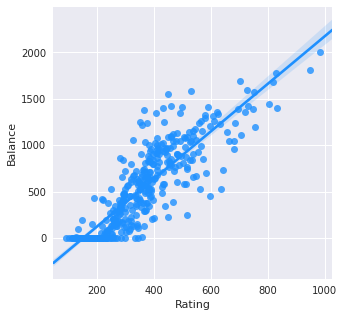

In [19]:
sns.set(style="darkgrid")
plt.figure(figsize=(5,5))
sns.regplot(df['Rating'], df['Balance'], color = 'dodgerblue');

/home/sebastiancz/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


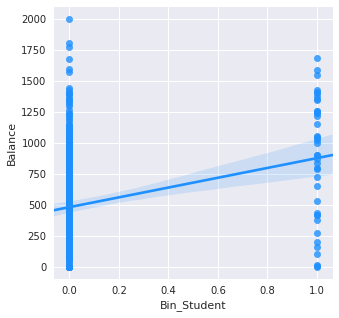

In [20]:
sns.set(style="darkgrid")
plt.figure(figsize=(5,5))
sns.regplot(df['Bin_Student'],df['Balance'], color = 'dodgerblue');

La variable `Rating` contiene un mayor poder explicativo la variabilidad de `Balance`.

Mientras que la variable `Student` no explica de manera suficiente el comportamiento de la variable `Balance`.

In [21]:
def hipotesis_a_mano(dataframe, variable, binarize):
    
    """
    Función que retorna la prueba de hipótesis, indicando el valor t, pvalue, media y comparación de medias entre la binarización de la variable a ingresar
    """

    bin_1 = dataframe.query(binarize + '== 1')[variable].dropna()
    bin_0 = dataframe.query(binarize + '== 0')[variable].dropna()
    
    print ("Valor t: {}".format((stats.ttest_ind(bin_1,bin_0))[0]))
    print ("Valor p: {}".format((stats.ttest_ind(bin_1,bin_0))[1]))
    print ("Media de {} para {} = 1: {}".format(variable, binarize, np.mean(bin_1)))
    print ("Media de {} para {} = 0: {}".format(variable, binarize, np.mean(bin_0)))
    print ("Diferencia entre medias: {}".format(np.abs(np.mean(bin_0)-np.mean(bin_1))))

In [22]:
hipotesis_a_mano(df,'Balance', 'Bin_Student')

Valor t: 5.349964123075003
Valor p: 1.4877341077323024e-07
Media de Balance para Bin_Student = 1: 876.825
Media de Balance para Bin_Student = 0: 480.36944444444447
Diferencia entre medias: 396.4555555555556


$Ho$ = No existen diferencias para la media variable `Balance` si es estudiante

Dado a que existe una diferencia entre las medias de la variable `Balance` para los estudiantes y no estudiantes, se rechaza $Ho$

## Ejercicio 4: Genere un modelo que incluya todos los regresores

![alttext](eq2.gif)

* Comente brevemente sobre el poder explicativo en la varianza de $y$ y las principales características de los predictores.

In [23]:
#el modelo ols no soporta nombres de variables con espacios, caracteres especiales, etc
df.columns = df.columns.map(lambda x: str(x).replace(' ','_'))

In [32]:
model1 = smf.ols('Balance ~ Income + Limit + Rating + Cards + Age + Education + African_American + Asian + Bin_Gender + Bin_Student + Bin_Married', df)
model1 = model1.fit()
results = model1.summary()
results.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-488.2880,34.816,-14.025,0.000,-556.740,-419.836
Income,-7.8031,0.234,-33.314,0.000,-8.264,-7.343
Limit,0.1909,0.033,5.824,0.000,0.126,0.255
Rating,1.1365,0.491,2.315,0.021,0.171,2.102
Cards,17.7245,4.341,4.083,0.000,9.190,26.259
Age,-0.6139,0.294,-2.088,0.037,-1.192,-0.036
Education,-1.0989,1.598,-0.688,0.492,-4.241,2.043
African_American,-10.1070,12.210,-0.828,0.408,-34.113,13.899
Asian,6.6972,12.122,0.552,0.581,-17.137,30.531
Bin_Gender,10.6532,9.914,1.075,0.283,-8.839,30.145


Los atributos con un nivel de significancia $p-value < .05$ explican de mejor manera el comportamiento de la variable objetivo y. Asimismo, al analizar los predictores que cumplan con la condición establecida, hace más sentido al estudiar la variable `Balance`, por ej, que la etnia del cliente no se un predictor significativo.

## Ejercicio 5: Depure el modelo e incluya sólo los predictores significativo

* En base al modelo anterior, refactorize e incluya sólo las variables con un nivel de significancia $p-value\leq.025$. Comente brevemente sobre el poder explicativo en la varianza de $y$ y las principales características de los predictores.
* ¿Mejoró o empeoró el modelo con la reducción de regresores?

In [39]:
model1 = smf.ols('Balance ~ Income + Limit + Rating + Cards + Bin_Student', df)
model1 = model1.fit()
results = model1.summary()
results.tables[0]

Dep. Variable:,Balance,R-squared:,0.954
Model:,OLS,Adj. R-squared:,0.954
Method:,Least Squares,F-statistic:,1640.
Date:,"Fri, 30 Nov 2018",Prob (F-statistic):,3.60e-261
Time:,23:40:07,Log-Likelihood:,-2402.8
No. Observations:,400,AIC:,4818.
Df Residuals:,394,BIC:,4842.
Df Model:,5,,
Covariance Type:,nonrobust,,


In [40]:
results.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-526.1555,19.747,-26.645,0.000,-564.977,-487.334
Income,-7.8749,0.231,-34.024,0.000,-8.330,-7.420
Limit,0.1944,0.033,5.977,0.000,0.130,0.258
Rating,1.0879,0.487,2.234,0.026,0.130,2.045
Cards,17.8517,4.335,4.118,0.000,9.329,26.374
Bin_Student,426.8501,16.574,25.754,0.000,394.266,459.435


Al reducir los regresores y seleccionar los atributos con un nivel de significancia $p-value\leq.025$ se puede observar un improvement en los resultados. Al analizar los resultados de la regresión, se puede apreciar que existe un R-cuadrado de 0.954 vs 0.746 que obtenía el modelo sólo con el atributo Rating.

## Ejercicio 6: 

* Utilizando `lmplot` de `seaborn`, inspeccione el comportamiento de los tres principales determinantes.

/home/sebastiancz/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


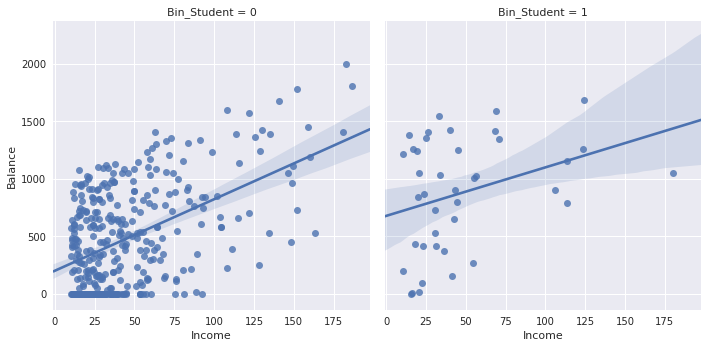

In [68]:
sns.lmplot(x='Income', y= 'Balance',data=df, col='Bin_Student');

/home/sebastiancz/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


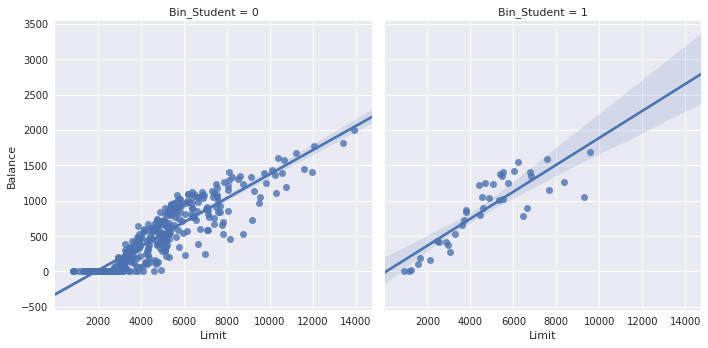

In [72]:
sns.lmplot(x='Limit', y= 'Balance',data=df, col='Bin_Student');

/home/sebastiancz/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


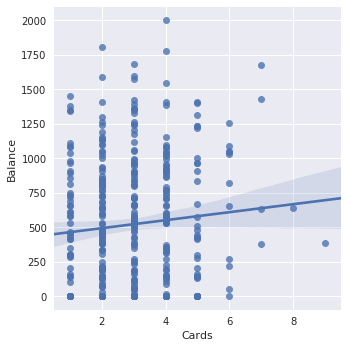

In [74]:
sns.lmplot(x='Cards', y= 'Balance',data=df);